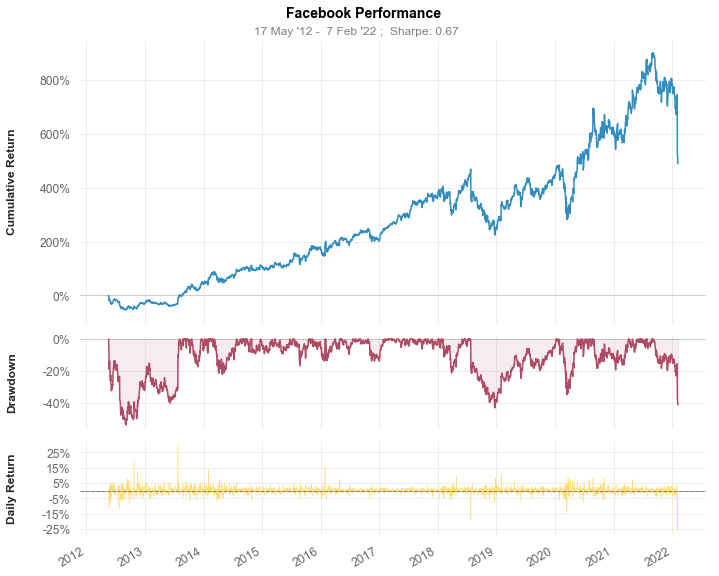

In [7]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('FB')
stock
qs.plots.snapshot(stock, title='Facebook Performance')

# show sharpe ratio
# qs.stats.sharpe(stock)

# or using extend_pandas() :)
# stock.sharpe()